![Redis](https://redis.io/wp-content/uploads/2024/04/Logotype.svg?auto=webp&quality=85,75&width=120)

# Retrieval Optimizer | Getting Started

This notebook will walk through how to get going optimizing your vector retrieval.

<a href="https://colab.research.google.com/github/redis-applied-ai/retrieval-optimizer/blob/main/examples/getting_started/retrieval_optimizer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1 - creating a dataset

For the retrieval optimization framework to run it requires a set of raw chunks and a set of queries with labeled chunks. The labeling tool can be used to generate these artifacts from an existing index or they can be created manually. See [README.md](../../README.md) for more information or checkout [populate_index.ipynb](./populate_index.ipynb).

For this demo, examples have been provided in the [data/](./data) directory. Let's see what they look like:

In [1]:
import json

with open("data/mazda_chunks.json", "r") as f:
    chunks = json.load(f)

chunks[0]

{'item_id': '119',
 'text': 'qMirror Defrosterí To turn on the mirror defrosters, turn the ignition switch to the ON position and push the rear window defroster switch (page 5-58).\n\nForm No.8Y64-EA-08A\n\nBlack plate (181,1)\n\nDriving Your Mazda Switches and Controls\n\nHorn\n\nTo sound the horn, press the the steering wheel.\n\nmark on\n\níSome models.\n\n5-59\n\nMazda3_8Y64-EA-08A_Edition1 Page182 Tuesday, November 27 2007 9:1 AM\n\nDriving Your Mazda Switches and Controls\n\nHazard Warning Flasher\n\nThe hazard warning lights should always be used when you stop on or near a roadway in an emergency.\n\nThe hazard warning lights warn other drivers that your vehicle is a traffic hazard and that they must take extreme caution when near it.\n\nHazard warning flasher\n\nDepress the hazard warning flasher and all the turn signals will flash.\n\nNOTE l The turn signals do not work when the\n\nhazard warning lights are on.\n\nl Check local regulations about the use of\n\nhazard warning li

In [2]:
with open("data/mazda_labeled.json", "r") as f:
    labeled = json.load(f)

labeled[0]

{'query': 'At what speed should I shift from 2 to 3 with a manual transmission?',
 'relevant_item_ids': ['86']}

#### Notes on the data

These jsons were generated using the labeling tool (see readme) however to run a study all you need to provide is a set of chunks of the form:

```json
[
    {
        "item_id": "chunk:123",
        "text": "raw content of the chunk"
    }
]
```

And a set of labeled queries:

```json
[
    {
        "query": "relevant question?",
        "relevant_item_ids": ["chunk:123"] // list of the relevant chunks to that question
    }
]
```

## 2 - python dependencies & env setup

This project utilizes poetry for dependency management. If you like, in the project root you can run `poetry install` then set the kernel version of this notebook to point to the path of the python interpreter poetry is referencing. This can be accomplish by running `poetry env info --path` after installing and setting as your kernel for the notebook.

Alternatively you can run the following line to import in a notebook native way for convenience.

In [3]:
%pip install numpy redisvl sentence-transformers redis optuna pandas nest-asyncio


[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


## Important!

The following code allows for us to run async functions in jupyter and adds the optimize module to path for easy import.

In [7]:
import sys
import os

# Add the parent directory to the Python path to get optimize module
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '../..')))

import nest_asyncio

# Apply the nest_asyncio patch: let's us run async code in Jupyter
nest_asyncio.apply()

## 3 - defining a study config

Under the hood, this framework is performing bayesian optimization utilizing the optuna library. This process determines the set of decision variables that best optimize the cost function. It accomplishes this by trying different combinations of the decision variables and intelligently traversing the solution space in the direction of best results.

At current the available decision variables are:

- algorithm ("hnsw" or "flat")
  - if hnsw secondary hyper-parameters of ef_runtime, ef_construction, and m can also be optimized.
- vector data type
- ret k
- embedding model

Different configurations of these variables will be attempted in order to **maximize** the following equation: `obj = w0 * f1 + w1 * norm_embedding_latency + w2 * norm_indexing_time` expressed in vector notation this is the dot product of `weights * metrics`. If there are additional metrics you would like to optimize over feel free to open an issue and we can look into adding it!

#### study_config.yaml
```yaml
input_data_type: "json" # currently only json but considering alternatives
raw_data_path: "data/mazda_chunks.json" # path to data files for easy read
labeled_data_path: "data/mazda_labeled.json" # labeled data

# optimization config
n_trials: 20
n_jobs: 1

# metrics to be used in objective function
metrics: ["f1_at_k", "embedding_latency", "total_indexing_time"] 
weights: [1, 1, 1] # weight of each metric respectively 

# optimization decision variables
algorithms: ["flat", "hnsw"] # indexing algorithms variables
vector_data_types: ["float32", "float16"] # vector type of indexed vectors
ret_k: [1, 10] # potential range of value to be sampled during study

# ef_runtime, ef_construction, and m only relevant if HNSW indexing
ef_runtime: [10, 20, 30, 50]
ef_construction: [100, 150, 200, 250, 300]
m: [8, 16, 64]

# embedding models to be used
embedding_models:
  - provider: "hf"
    model: "sentence-transformers/all-MiniLM-L6-v2"
    dim: 384
  - provider: "hf"
    model: "intfloat/e5-large-v2"
    dim: 1024
```

#### Load the study config


In [8]:
from optimize.study import load_config

study_config = load_config("study_config.yaml") # Loads yaml into pydantic model

study_config.embedding_models[1]

EmbeddingModel(provider='hf', model='intfloat/e5-large-v2', dim=1024)

# 4 - running a redis instance

For the following code to work we need to have a running instance of redis. 

The easiest way to do this is with docker:

`docker run -d --name redis -p 6379:6379 -p 8001:8001 redis/redis-stack:latest`

#### Note: running redis-stack will expose a GUI (Redis Insight) for interacting with your data on port 8001

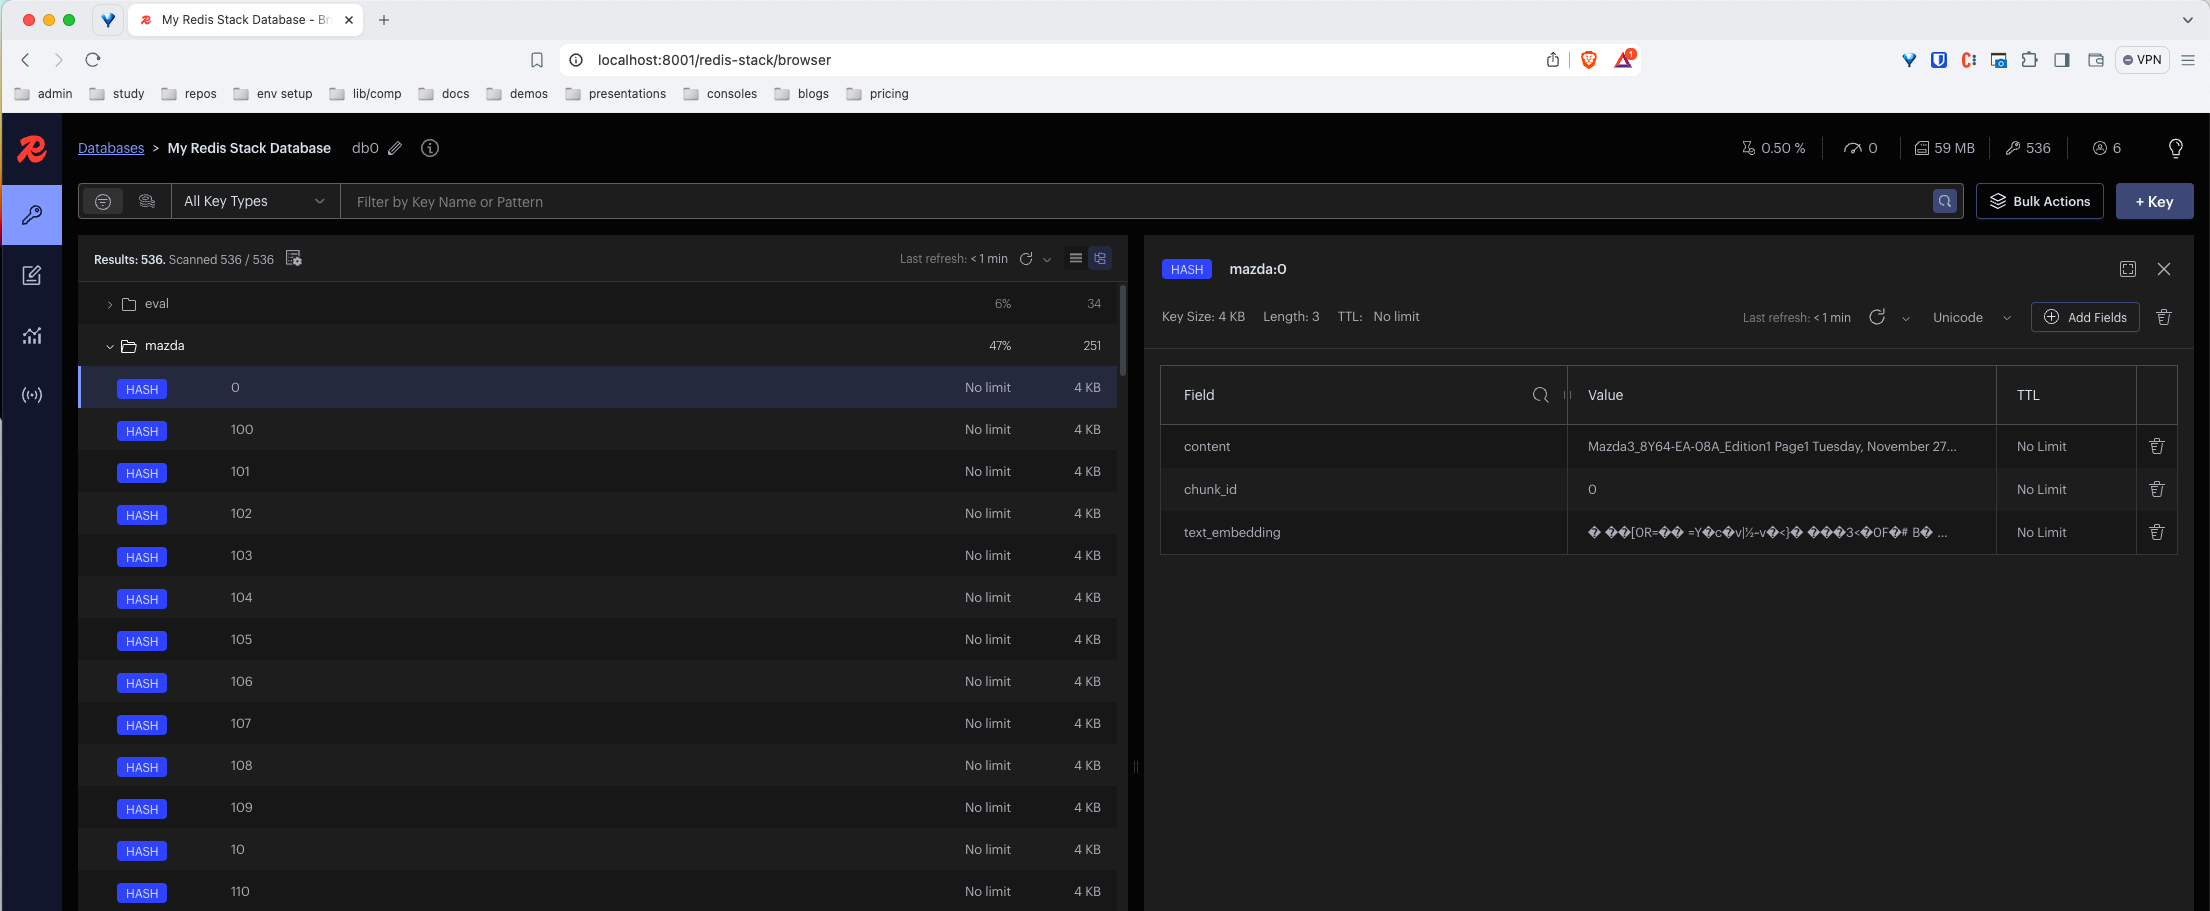

# 5 - understanding the eval class

The optimization works by instantiating different variation of the eval class and running calc metrics. Let's run an evaluation to get a baseline for our study.

In [9]:
from optimize.eval import Eval

e = Eval(
    model_provider="hf",
    model_str="intfloat/e5-large-v2",
    embedding_dim=1024,
    raw_data_path=study_config.raw_data_path,
    labeled_data_path=study_config.labeled_data_path,
    input_data_type=study_config.input_data_type,
    vector_data_type=study_config.vector_data_types[0],
    algorithm=study_config.algorithms[0],
    ret_k=4,
    find_threshold=False,
    redis_url="redis://localhost:6381/0",
)

2024-11-27 11:22:45,220 - INFO - Load pretrained SentenceTransformer: intfloat/e5-large-v2
2024-11-27 11:22:49,807 - INFO - Use pytorch device_name: mps


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

2024-11-27 11:23:07,099 - INFO - Indexing data...
2024-11-27 11:23:07,172 - INFO - Data indexed. self.total_indexing_time=60.57899856567383s


## What just happened?

1. eval class embedded the chunks with the specified model
2. created a search index in redis
3. loaded the chunks into the index

#### Now let's calculate some metrics!

In [10]:
e.calc_metrics()

2024-11-27 11:23:14,411 - INFO - Load pretrained SentenceTransformer: intfloat/e5-large-v2
2024-11-27 11:23:17,085 - INFO - Use pytorch device_name: mps


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2024-11-27 11:23:20,358 - INFO - Calculating retrieval metrics for test_id: 3f3b8b52-0aa2-4f22-b58a-712d24cbe735
2024-11-27 11:23:20,368 - INFO - Overall f1 at 4 for retrieval: 0.5003968253968254


#### What just happened?

- the queries provided in the label section were run against the index and the result recorded
- precision, recall, and f1 @k were calculated for the configuration
- results and metadata of the eval was persisted to redis

For each test a UUID is created and information stored in redis. The following shows the test_id and the overall f1 score

In [11]:
e.settings.test_id, e.f1_at_k, e.avg_query_latency

('3f3b8b52-0aa2-4f22-b58a-712d24cbe735',
 0.5003968253968254,
 0.008097648620605469)

Going back to redis insight you can see the full results of this test and the distance samples

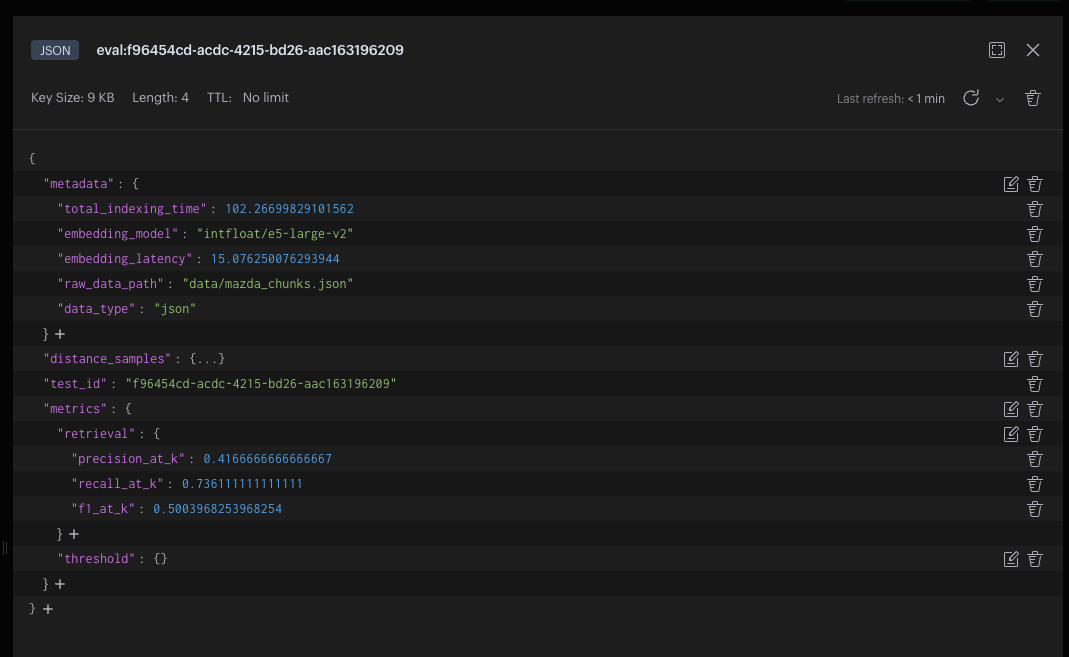

# 6 - running an optimization

Now that we understand the components let's run a study.

In [12]:
from optimize.study import run_study

run_study(study_config)

[I 2024-11-27 11:23:55,319] A new study created in memory with name: test
2024-11-27 11:23:55,320 - INFO - Running for Retriever: DefaultQueryRetriever with additional_schema_fields=None




 Running for: 
 model_str: intfloat/e5-large-v2 
 algorithm: flat


2024-11-27 11:24:01,076 - INFO - Load pretrained SentenceTransformer: intfloat/e5-large-v2
2024-11-27 11:24:04,135 - INFO - Use pytorch device_name: mps


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

2024-11-27 11:24:21,238 - INFO - Indexing data...
2024-11-27 11:24:48,280 - INFO - ...
2024-11-27 11:24:50,170 - INFO - ...
2024-11-27 11:24:51,237 - INFO - ...
2024-11-27 11:24:52,899 - INFO - ...
2024-11-27 11:24:55,004 - INFO - ...
2024-11-27 11:24:57,253 - INFO - ...
2024-11-27 11:24:59,218 - INFO - ...
2024-11-27 11:25:00,978 - INFO - ...
2024-11-27 11:25:02,651 - INFO - ...
2024-11-27 11:25:03,736 - INFO - ...
2024-11-27 11:25:05,948 - INFO - ...
2024-11-27 11:25:07,806 - INFO - ...
2024-11-27 11:25:09,561 - INFO - ...
2024-11-27 11:25:11,771 - INFO - ...
2024-11-27 11:25:13,261 - INFO - ...
2024-11-27 11:25:15,474 - INFO - ...
2024-11-27 11:25:17,386 - INFO - ...
2024-11-27 11:25:19,655 - INFO - ...
2024-11-27 11:25:21,342 - INFO - ...
2024-11-27 11:25:23,381 - INFO - ...
2024-11-27 11:25:25,625 - INFO - ...
2024-11-27 11:25:27,419 - INFO - ...
2024-11-27 11:25:28,511 - INFO - ...
2024-11-27 11:25:30,487 - INFO - ...
2024-11-27 11:25:32,989 - INFO - ...
2024-11-27 11:25:35,332 -

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2024-11-27 11:38:43,463 - INFO - Calculating retrieval metrics for test_id: 233e17e0-d107-4dd1-8c66-271fd2f89b7b
2024-11-27 11:38:43,478 - INFO - Overall f1 at 2 for retrieval: 0.49166666666666664
[I 2024-11-27 11:38:43,486] Trial 0 finished with value: 0.5524810801021469 and parameters: {'model_info': {'provider': 'hf', 'model': 'intfloat/e5-large-v2', 'dim': 1024}, 'algorithm': 'flat', 'var_dtype': 'float32', 'ret_k': 2}. Best is trial 0 with value: 0.5524810801021469.
2024-11-27 11:38:43,489 - INFO - Running for Retriever: DefaultQueryRetriever with additional_schema_fields=None
2024-11-27 11:38:43,509 - INFO - Load pretrained SentenceTransformer: intfloat/e5-large-v2




 Running for: 
 model_str: intfloat/e5-large-v2 
 algorithm: flat


2024-11-27 11:38:45,204 - INFO - Use pytorch device_name: mps


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

2024-11-27 11:39:06,863 - INFO - Indexing data...
2024-11-27 11:39:10,515 - INFO - ...
2024-11-27 11:39:11,522 - INFO - ...
2024-11-27 11:39:12,535 - INFO - ...
2024-11-27 11:39:13,641 - INFO - ...
2024-11-27 11:39:14,670 - INFO - ...
2024-11-27 11:39:15,681 - INFO - ...
2024-11-27 11:39:16,691 - INFO - ...
2024-11-27 11:39:17,699 - INFO - ...
2024-11-27 11:39:17,706 - INFO - Data indexed. self.total_indexing_time=16878.69921875s
2024-11-27 11:39:17,803 - INFO - Load pretrained SentenceTransformer: intfloat/e5-large-v2
2024-11-27 11:39:21,278 - INFO - Use pytorch device_name: mps


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2024-11-27 11:39:25,005 - INFO - Calculating retrieval metrics for test_id: be789847-d7d2-4d91-b0be-612d319dee0b
2024-11-27 11:39:25,042 - INFO - Overall f1 at 8 for retrieval: 0.37765752765752775
[I 2024-11-27 11:39:25,045] Trial 1 finished with value: 0.42410162553693126 and parameters: {'model_info': {'provider': 'hf', 'model': 'intfloat/e5-large-v2', 'dim': 1024}, 'algorithm': 'flat', 'var_dtype': 'float32', 'ret_k': 8}. Best is trial 0 with value: 0.5524810801021469.
2024-11-27 11:39:25,046 - INFO - Running for Retriever: DefaultQueryRetriever with additional_schema_fields=None
2024-11-27 11:39:25,066 - INFO - Load pretrained SentenceTransformer: sentence-transformers/all-MiniLM-L6-v2




 Running for: 
 model_str: sentence-transformers/all-MiniLM-L6-v2 
 ef_runtime: 10 
 ef_construction: 250 
 m: 16 




2024-11-27 11:39:26,000 - INFO - Use pytorch device_name: mps


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

2024-11-27 11:39:28,745 - INFO - Indexing data...
2024-11-27 11:39:32,128 - INFO - ...
2024-11-27 11:39:33,209 - INFO - ...
2024-11-27 11:39:34,223 - INFO - ...
2024-11-27 11:39:35,230 - INFO - ...
2024-11-27 11:39:36,240 - INFO - ...
2024-11-27 11:39:37,939 - INFO - ...
2024-11-27 11:39:39,166 - INFO - ...
2024-11-27 11:39:40,174 - INFO - ...
2024-11-27 11:39:41,183 - INFO - ...
2024-11-27 11:39:42,196 - INFO - ...
2024-11-27 11:39:43,203 - INFO - ...
2024-11-27 11:39:44,220 - INFO - ...
2024-11-27 11:39:44,230 - INFO - Data indexed. self.total_indexing_time=12954.7890625s
2024-11-27 11:39:44,281 - INFO - Load pretrained SentenceTransformer: sentence-transformers/all-MiniLM-L6-v2
2024-11-27 11:39:45,360 - INFO - Use pytorch device_name: mps


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2024-11-27 11:39:48,006 - INFO - Calculating retrieval metrics for test_id: 7fade9ea-48b8-43ba-8a0d-09704ad748b2
2024-11-27 11:39:48,016 - INFO - Overall f1 at 2 for retrieval: 0.65
[I 2024-11-27 11:39:48,020] Trial 2 finished with value: 0.9698636075136011 and parameters: {'model_info': {'provider': 'hf', 'model': 'sentence-transformers/all-MiniLM-L6-v2', 'dim': 384}, 'algorithm': 'hnsw', 'var_dtype': 'float32', 'ret_k': 2, 'ef_runtime': 10, 'ef_construction': 250, 'm': 16}. Best is trial 2 with value: 0.9698636075136011.
2024-11-27 11:39:48,026 - INFO - Running for Retriever: DefaultQueryRetriever with additional_schema_fields=None
2024-11-27 11:39:48,053 - INFO - Load pretrained SentenceTransformer: intfloat/e5-large-v2




 Running for: 
 model_str: intfloat/e5-large-v2 
 ef_runtime: 10 
 ef_construction: 200 
 m: 64 




2024-11-27 11:39:53,854 - INFO - Use pytorch device_name: mps


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

2024-11-27 11:40:27,772 - INFO - Indexing data...
2024-11-27 11:40:29,759 - INFO - Data indexed. self.total_indexing_time=16326.259765625s
2024-11-27 11:40:29,777 - INFO - Load pretrained SentenceTransformer: intfloat/e5-large-v2
2024-11-27 11:40:34,866 - INFO - Use pytorch device_name: mps


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2024-11-27 11:40:37,955 - INFO - Calculating retrieval metrics for test_id: 3ebb8389-b382-4af7-9a47-e417f8ea04de
2024-11-27 11:40:37,988 - INFO - Overall f1 at 5 for retrieval: 0.37668350168350173
[I 2024-11-27 11:40:38,000] Trial 3 finished with value: 0.4074536099386067 and parameters: {'model_info': {'provider': 'hf', 'model': 'intfloat/e5-large-v2', 'dim': 1024}, 'algorithm': 'hnsw', 'var_dtype': 'float16', 'ret_k': 5, 'ef_runtime': 10, 'ef_construction': 200, 'm': 64}. Best is trial 2 with value: 0.9698636075136011.
2024-11-27 11:40:38,003 - INFO - Running for Retriever: DefaultQueryRetriever with additional_schema_fields=None
2024-11-27 11:40:38,033 - INFO - Load pretrained SentenceTransformer: intfloat/e5-large-v2




 Running for: 
 model_str: intfloat/e5-large-v2 
 algorithm: flat


2024-11-27 11:40:41,445 - INFO - Use pytorch device_name: mps


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

2024-11-27 11:41:14,479 - INFO - Indexing data...
2024-11-27 11:41:18,471 - INFO - Data indexed. self.total_indexing_time=14419.185546875s
2024-11-27 11:41:18,488 - INFO - Load pretrained SentenceTransformer: intfloat/e5-large-v2
2024-11-27 11:41:21,292 - INFO - Use pytorch device_name: mps


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2024-11-27 11:41:25,254 - INFO - Calculating retrieval metrics for test_id: 61279386-4d47-4cfb-8746-e4f9e2e71870
2024-11-27 11:41:25,284 - INFO - Overall f1 at 7 for retrieval: 0.38826081326081324
[I 2024-11-27 11:41:25,292] Trial 4 finished with value: 0.41946418833862237 and parameters: {'model_info': {'provider': 'hf', 'model': 'intfloat/e5-large-v2', 'dim': 1024}, 'algorithm': 'flat', 'var_dtype': 'float16', 'ret_k': 7}. Best is trial 2 with value: 0.9698636075136011.
2024-11-27 11:41:25,313 - INFO - Running for Retriever: DefaultQueryRetriever with additional_schema_fields=None
2024-11-27 11:41:25,382 - INFO - Load pretrained SentenceTransformer: sentence-transformers/all-MiniLM-L6-v2




 Running for: 
 model_str: sentence-transformers/all-MiniLM-L6-v2 
 ef_runtime: 30 
 ef_construction: 250 
 m: 16 




2024-11-27 11:41:26,113 - INFO - Use pytorch device_name: mps


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

2024-11-27 11:41:28,425 - INFO - Indexing data...
2024-11-27 11:41:31,653 - INFO - ...
2024-11-27 11:41:32,710 - INFO - ...
2024-11-27 11:41:33,724 - INFO - ...
2024-11-27 11:41:34,734 - INFO - ...
2024-11-27 11:41:35,741 - INFO - ...
2024-11-27 11:41:36,749 - INFO - ...
2024-11-27 11:41:37,756 - INFO - ...
2024-11-27 11:41:38,762 - INFO - ...
2024-11-27 11:41:39,772 - INFO - ...
2024-11-27 11:41:40,779 - INFO - ...
2024-11-27 11:41:40,794 - INFO - Data indexed. self.total_indexing_time=9929.31640625s
2024-11-27 11:41:40,858 - INFO - Load pretrained SentenceTransformer: sentence-transformers/all-MiniLM-L6-v2
2024-11-27 11:41:41,826 - INFO - Use pytorch device_name: mps


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2024-11-27 11:41:44,092 - INFO - Calculating retrieval metrics for test_id: 85d0b25d-1fbf-434b-b97f-cdbbbf4e44a7
2024-11-27 11:41:44,101 - INFO - Overall f1 at 7 for retrieval: 0.4884550634550635
[I 2024-11-27 11:41:44,104] Trial 5 finished with value: 0.8077661898955641 and parameters: {'model_info': {'provider': 'hf', 'model': 'sentence-transformers/all-MiniLM-L6-v2', 'dim': 384}, 'algorithm': 'hnsw', 'var_dtype': 'float32', 'ret_k': 7, 'ef_runtime': 30, 'ef_construction': 250, 'm': 16}. Best is trial 2 with value: 0.9698636075136011.
2024-11-27 11:41:44,105 - INFO - Running for Retriever: DefaultQueryRetriever with additional_schema_fields=None
2024-11-27 11:41:44,133 - INFO - Load pretrained SentenceTransformer: sentence-transformers/all-MiniLM-L6-v2




 Running for: 
 model_str: sentence-transformers/all-MiniLM-L6-v2 
 algorithm: flat


2024-11-27 11:41:45,003 - INFO - Use pytorch device_name: mps


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

2024-11-27 11:41:46,912 - INFO - Indexing data...
2024-11-27 11:41:56,939 - INFO - ...
2024-11-27 11:41:57,956 - INFO - ...
2024-11-27 11:41:58,962 - INFO - ...
2024-11-27 11:41:59,970 - INFO - ...
2024-11-27 11:42:00,998 - INFO - ...
2024-11-27 11:42:02,102 - INFO - ...
2024-11-27 11:42:03,109 - INFO - ...
2024-11-27 11:42:04,116 - INFO - ...
2024-11-27 11:42:05,132 - INFO - ...
2024-11-27 11:42:06,187 - INFO - ...
2024-11-27 11:42:07,345 - INFO - ...
2024-11-27 11:42:08,360 - INFO - ...
2024-11-27 11:42:09,367 - INFO - ...
2024-11-27 11:42:10,395 - INFO - ...
2024-11-27 11:42:11,403 - INFO - ...
2024-11-27 11:42:12,415 - INFO - ...
2024-11-27 11:42:13,426 - INFO - ...
2024-11-27 11:42:14,439 - INFO - ...
2024-11-27 11:42:15,460 - INFO - ...
2024-11-27 11:42:16,526 - INFO - ...
2024-11-27 11:42:17,538 - INFO - ...
2024-11-27 11:42:18,548 - INFO - ...
2024-11-27 11:42:19,557 - INFO - ...
2024-11-27 11:42:20,712 - INFO - ...
2024-11-27 11:42:21,729 - INFO - ...
2024-11-27 11:42:22,751 -

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2024-11-27 11:42:54,460 - INFO - Calculating retrieval metrics for test_id: 028ad36b-7e1b-4533-a3b6-ecc89415e354
2024-11-27 11:42:54,472 - INFO - Overall f1 at 4 for retrieval: 0.3837301587301587
[I 2024-11-27 11:42:54,474] Trial 6 finished with value: 0.7393537576147934 and parameters: {'model_info': {'provider': 'hf', 'model': 'sentence-transformers/all-MiniLM-L6-v2', 'dim': 384}, 'algorithm': 'flat', 'var_dtype': 'float16', 'ret_k': 4}. Best is trial 2 with value: 0.9698636075136011.
2024-11-27 11:42:54,475 - INFO - Running for Retriever: DefaultQueryRetriever with additional_schema_fields=None
2024-11-27 11:42:54,491 - INFO - Load pretrained SentenceTransformer: intfloat/e5-large-v2




 Running for: 
 model_str: intfloat/e5-large-v2 
 ef_runtime: 50 
 ef_construction: 150 
 m: 16 




2024-11-27 11:42:59,515 - INFO - Use pytorch device_name: mps


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

2024-11-27 11:43:51,694 - INFO - Indexing data...
2024-11-27 11:44:03,635 - INFO - Data indexed. self.total_indexing_time=18692.1640625s
2024-11-27 11:44:03,726 - INFO - Load pretrained SentenceTransformer: intfloat/e5-large-v2
2024-11-27 11:44:08,527 - INFO - Use pytorch device_name: mps


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2024-11-27 11:44:19,650 - INFO - Calculating retrieval metrics for test_id: bb7dcd8f-9140-41b0-9eda-0f4df437d5a1
2024-11-27 11:44:19,688 - INFO - Overall f1 at 7 for retrieval: 0.38826081326081324
[I 2024-11-27 11:44:19,693] Trial 7 finished with value: 0.4121434241323299 and parameters: {'model_info': {'provider': 'hf', 'model': 'intfloat/e5-large-v2', 'dim': 1024}, 'algorithm': 'hnsw', 'var_dtype': 'float32', 'ret_k': 7, 'ef_runtime': 50, 'ef_construction': 150, 'm': 16}. Best is trial 2 with value: 0.9698636075136011.
2024-11-27 11:44:19,701 - INFO - Running for Retriever: DefaultQueryRetriever with additional_schema_fields=None
2024-11-27 11:44:19,718 - INFO - Load pretrained SentenceTransformer: intfloat/e5-large-v2




 Running for: 
 model_str: intfloat/e5-large-v2 
 algorithm: flat


2024-11-27 11:44:24,720 - INFO - Use pytorch device_name: mps


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

2024-11-27 11:45:12,851 - INFO - Indexing data...
2024-11-27 11:45:16,407 - INFO - Data indexed. self.total_indexing_time=18844.81640625s
2024-11-27 11:45:16,581 - INFO - Load pretrained SentenceTransformer: intfloat/e5-large-v2
2024-11-27 11:45:19,843 - INFO - Use pytorch device_name: mps


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2024-11-27 11:45:27,972 - INFO - Calculating retrieval metrics for test_id: 8058f68d-dcde-481b-ba12-ab1c4edae8c7
2024-11-27 11:45:28,162 - INFO - Overall f1 at 6 for retrieval: 0.4332671957671958
[I 2024-11-27 11:45:28,168] Trial 8 finished with value: 0.4547337982756203 and parameters: {'model_info': {'provider': 'hf', 'model': 'intfloat/e5-large-v2', 'dim': 1024}, 'algorithm': 'flat', 'var_dtype': 'float16', 'ret_k': 6}. Best is trial 2 with value: 0.9698636075136011.
2024-11-27 11:45:28,269 - INFO - Running for Retriever: DefaultQueryRetriever with additional_schema_fields=None




 Running for: 
 model_str: intfloat/e5-large-v2 
 algorithm: flat


2024-11-27 11:45:28,563 - INFO - Load pretrained SentenceTransformer: intfloat/e5-large-v2
2024-11-27 11:45:32,120 - INFO - Use pytorch device_name: mps


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

2024-11-27 11:46:13,434 - INFO - Indexing data...
2024-11-27 11:46:16,196 - INFO - Data indexed. self.total_indexing_time=32532.939453125s
2024-11-27 11:46:16,239 - INFO - Load pretrained SentenceTransformer: intfloat/e5-large-v2
2024-11-27 11:46:20,459 - INFO - Use pytorch device_name: mps


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2024-11-27 11:46:23,964 - INFO - Calculating retrieval metrics for test_id: eda6a45c-0f05-4d2b-b373-b5b6ef4ff38f
2024-11-27 11:46:23,993 - INFO - Overall f1 at 8 for retrieval: 0.37765752765752775
[I 2024-11-27 11:46:23,998] Trial 9 finished with value: 0.4024773652603096 and parameters: {'model_info': {'provider': 'hf', 'model': 'intfloat/e5-large-v2', 'dim': 1024}, 'algorithm': 'flat', 'var_dtype': 'float32', 'ret_k': 8}. Best is trial 2 with value: 0.9698636075136011.
2024-11-27 11:46:24,022 - INFO - Running for Retriever: DefaultQueryRetriever with additional_schema_fields=None
2024-11-27 11:46:24,054 - INFO - Load pretrained SentenceTransformer: sentence-transformers/all-MiniLM-L6-v2




 Running for: 
 model_str: sentence-transformers/all-MiniLM-L6-v2 
 ef_runtime: 10 
 ef_construction: 100 
 m: 8 




2024-11-27 11:46:25,483 - INFO - Use pytorch device_name: mps


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

2024-11-27 11:46:27,347 - INFO - Indexing data...
2024-11-27 11:46:30,137 - INFO - ...
2024-11-27 11:46:31,146 - INFO - ...
2024-11-27 11:46:32,151 - INFO - ...
2024-11-27 11:46:33,193 - INFO - ...
2024-11-27 11:46:34,205 - INFO - ...
2024-11-27 11:46:35,213 - INFO - ...
2024-11-27 11:46:36,226 - INFO - ...
2024-11-27 11:46:37,235 - INFO - ...
2024-11-27 11:46:38,247 - INFO - ...
2024-11-27 11:46:38,254 - INFO - Data indexed. self.total_indexing_time=9391.7822265625s
2024-11-27 11:46:38,277 - INFO - Load pretrained SentenceTransformer: sentence-transformers/all-MiniLM-L6-v2
2024-11-27 11:46:39,086 - INFO - Use pytorch device_name: mps


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2024-11-27 11:46:40,703 - INFO - Calculating retrieval metrics for test_id: f44bb26f-5f57-4ad7-8e31-07ab75a56df2
2024-11-27 11:46:40,713 - INFO - Overall f1 at 1 for retrieval: 0.5432539682539683
[I 2024-11-27 11:46:40,714] Trial 10 finished with value: 0.9291754283228413 and parameters: {'model_info': {'provider': 'hf', 'model': 'sentence-transformers/all-MiniLM-L6-v2', 'dim': 384}, 'algorithm': 'hnsw', 'var_dtype': 'float32', 'ret_k': 1, 'ef_runtime': 10, 'ef_construction': 100, 'm': 8}. Best is trial 2 with value: 0.9698636075136011.
2024-11-27 11:46:40,715 - INFO - Running for Retriever: DefaultQueryRetriever with additional_schema_fields=None
2024-11-27 11:46:40,781 - INFO - Load pretrained SentenceTransformer: sentence-transformers/all-MiniLM-L6-v2




 Running for: 
 model_str: sentence-transformers/all-MiniLM-L6-v2 
 ef_runtime: 10 
 ef_construction: 100 
 m: 8 




2024-11-27 11:46:41,516 - INFO - Use pytorch device_name: mps


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

2024-11-27 11:46:43,527 - INFO - Indexing data...
2024-11-27 11:46:47,443 - INFO - ...
2024-11-27 11:46:48,453 - INFO - ...
2024-11-27 11:46:49,762 - INFO - ...
2024-11-27 11:46:50,783 - INFO - ...
2024-11-27 11:46:52,150 - INFO - ...
2024-11-27 11:46:53,250 - INFO - ...
2024-11-27 11:46:54,257 - INFO - ...
2024-11-27 11:46:55,263 - INFO - ...
2024-11-27 11:46:56,271 - INFO - ...
2024-11-27 11:46:57,333 - INFO - ...
2024-11-27 11:46:58,341 - INFO - ...
2024-11-27 11:46:59,344 - INFO - ...
2024-11-27 11:47:00,354 - INFO - ...
2024-11-27 11:47:00,363 - INFO - Data indexed. self.total_indexing_time=12371.37109375s
2024-11-27 11:47:00,388 - INFO - Load pretrained SentenceTransformer: sentence-transformers/all-MiniLM-L6-v2
2024-11-27 11:47:01,047 - INFO - Use pytorch device_name: mps


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2024-11-27 11:47:03,173 - INFO - Calculating retrieval metrics for test_id: ce851593-9f80-4b80-b68f-eeb9fc2b8c14
2024-11-27 11:47:03,193 - INFO - Overall f1 at 1 for retrieval: 0.5432539682539683
[I 2024-11-27 11:47:03,196] Trial 11 finished with value: 0.8857162241606011 and parameters: {'model_info': {'provider': 'hf', 'model': 'sentence-transformers/all-MiniLM-L6-v2', 'dim': 384}, 'algorithm': 'hnsw', 'var_dtype': 'float32', 'ret_k': 1, 'ef_runtime': 10, 'ef_construction': 100, 'm': 8}. Best is trial 2 with value: 0.9698636075136011.
2024-11-27 11:47:03,199 - INFO - Running for Retriever: DefaultQueryRetriever with additional_schema_fields=None
2024-11-27 11:47:03,231 - INFO - Load pretrained SentenceTransformer: sentence-transformers/all-MiniLM-L6-v2




 Running for: 
 model_str: sentence-transformers/all-MiniLM-L6-v2 
 ef_runtime: 10 
 ef_construction: 250 
 m: 8 




2024-11-27 11:47:03,925 - INFO - Use pytorch device_name: mps


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

2024-11-27 11:47:05,921 - INFO - Indexing data...
2024-11-27 11:47:10,536 - INFO - ...
2024-11-27 11:47:11,544 - INFO - ...
2024-11-27 11:47:12,553 - INFO - ...
2024-11-27 11:47:13,556 - INFO - ...
2024-11-27 11:47:14,563 - INFO - ...
2024-11-27 11:47:15,586 - INFO - ...
2024-11-27 11:47:16,591 - INFO - ...
2024-11-27 11:47:17,601 - INFO - ...
2024-11-27 11:47:18,613 - INFO - ...
2024-11-27 11:47:19,636 - INFO - ...
2024-11-27 11:47:20,650 - INFO - ...
2024-11-27 11:47:21,705 - INFO - ...
2024-11-27 11:47:21,732 - INFO - Data indexed. self.total_indexing_time=11042.8623046875s
2024-11-27 11:47:21,757 - INFO - Load pretrained SentenceTransformer: sentence-transformers/all-MiniLM-L6-v2
2024-11-27 11:47:22,739 - INFO - Use pytorch device_name: mps


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2024-11-27 11:47:24,483 - INFO - Calculating retrieval metrics for test_id: 9ade21ca-2398-4b88-81ce-89d5ba71b0c9
2024-11-27 11:47:24,489 - INFO - Overall f1 at 3 for retrieval: 0.6603174603174603
[I 2024-11-27 11:47:24,492] Trial 12 finished with value: 1.0030430649073432 and parameters: {'model_info': {'provider': 'hf', 'model': 'sentence-transformers/all-MiniLM-L6-v2', 'dim': 384}, 'algorithm': 'hnsw', 'var_dtype': 'float32', 'ret_k': 3, 'ef_runtime': 10, 'ef_construction': 250, 'm': 8}. Best is trial 12 with value: 1.0030430649073432.
2024-11-27 11:47:24,493 - INFO - Running for Retriever: DefaultQueryRetriever with additional_schema_fields=None
2024-11-27 11:47:24,589 - INFO - Load pretrained SentenceTransformer: sentence-transformers/all-MiniLM-L6-v2




 Running for: 
 model_str: sentence-transformers/all-MiniLM-L6-v2 
 ef_runtime: 20 
 ef_construction: 250 
 m: 16 




2024-11-27 11:47:25,457 - INFO - Use pytorch device_name: mps


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

2024-11-27 11:47:27,411 - INFO - Indexing data...
2024-11-27 11:47:32,360 - INFO - ...
2024-11-27 11:47:33,365 - INFO - ...
2024-11-27 11:47:34,374 - INFO - ...
2024-11-27 11:47:35,381 - INFO - ...
2024-11-27 11:47:36,388 - INFO - ...
2024-11-27 11:47:37,395 - INFO - ...
2024-11-27 11:47:38,406 - INFO - ...
2024-11-27 11:47:39,417 - INFO - ...
2024-11-27 11:47:40,427 - INFO - ...
2024-11-27 11:47:41,431 - INFO - ...
2024-11-27 11:47:41,436 - INFO - Data indexed. self.total_indexing_time=9920.47265625s
2024-11-27 11:47:41,453 - INFO - Load pretrained SentenceTransformer: sentence-transformers/all-MiniLM-L6-v2
2024-11-27 11:47:42,238 - INFO - Use pytorch device_name: mps


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2024-11-27 11:47:44,128 - INFO - Calculating retrieval metrics for test_id: fedee8c8-6d24-4f51-ad62-760410167ac9
2024-11-27 11:47:44,143 - INFO - Overall f1 at 3 for retrieval: 0.6603174603174603
[I 2024-11-27 11:47:44,146] Trial 13 finished with value: 1.007426732628181 and parameters: {'model_info': {'provider': 'hf', 'model': 'sentence-transformers/all-MiniLM-L6-v2', 'dim': 384}, 'algorithm': 'hnsw', 'var_dtype': 'float32', 'ret_k': 3, 'ef_runtime': 20, 'ef_construction': 250, 'm': 16}. Best is trial 13 with value: 1.007426732628181.
2024-11-27 11:47:44,148 - INFO - Running for Retriever: DefaultQueryRetriever with additional_schema_fields=None
2024-11-27 11:47:44,176 - INFO - Load pretrained SentenceTransformer: sentence-transformers/all-MiniLM-L6-v2




 Running for: 
 model_str: sentence-transformers/all-MiniLM-L6-v2 
 ef_runtime: 20 
 ef_construction: 250 
 m: 8 




2024-11-27 11:47:45,154 - INFO - Use pytorch device_name: mps


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

2024-11-27 11:47:47,099 - INFO - Indexing data...
2024-11-27 11:47:51,436 - INFO - ...
2024-11-27 11:47:52,450 - INFO - ...
2024-11-27 11:47:53,459 - INFO - ...
2024-11-27 11:47:54,467 - INFO - ...
2024-11-27 11:47:55,474 - INFO - ...
2024-11-27 11:47:56,482 - INFO - ...
2024-11-27 11:47:57,490 - INFO - ...
2024-11-27 11:47:58,497 - INFO - ...
2024-11-27 11:47:59,505 - INFO - ...
2024-11-27 11:47:59,514 - INFO - Data indexed. self.total_indexing_time=8686.2333984375s
2024-11-27 11:47:59,533 - INFO - Load pretrained SentenceTransformer: sentence-transformers/all-MiniLM-L6-v2
2024-11-27 11:48:00,327 - INFO - Use pytorch device_name: mps


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2024-11-27 11:48:02,285 - INFO - Calculating retrieval metrics for test_id: 82cfb418-55dc-4dde-9c33-fd5b64708584
2024-11-27 11:48:02,304 - INFO - Overall f1 at 3 for retrieval: 0.6603174603174603
[I 2024-11-27 11:48:02,306] Trial 14 finished with value: 1.0108533762611567 and parameters: {'model_info': {'provider': 'hf', 'model': 'sentence-transformers/all-MiniLM-L6-v2', 'dim': 384}, 'algorithm': 'hnsw', 'var_dtype': 'float32', 'ret_k': 3, 'ef_runtime': 20, 'ef_construction': 250, 'm': 8}. Best is trial 14 with value: 1.0108533762611567.
2024-11-27 11:48:02,307 - INFO - Running for Retriever: DefaultQueryRetriever with additional_schema_fields=None
2024-11-27 11:48:02,325 - INFO - Load pretrained SentenceTransformer: sentence-transformers/all-MiniLM-L6-v2




 Running for: 
 model_str: sentence-transformers/all-MiniLM-L6-v2 
 ef_runtime: 20 
 ef_construction: 300 
 m: 64 




2024-11-27 11:48:03,044 - INFO - Use pytorch device_name: mps


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

2024-11-27 11:48:04,966 - INFO - Indexing data...
2024-11-27 11:48:09,349 - INFO - ...
2024-11-27 11:48:10,356 - INFO - ...
2024-11-27 11:48:11,363 - INFO - ...
2024-11-27 11:48:12,368 - INFO - ...
2024-11-27 11:48:13,373 - INFO - ...
2024-11-27 11:48:14,380 - INFO - ...
2024-11-27 11:48:15,386 - INFO - ...
2024-11-27 11:48:16,419 - INFO - ...
2024-11-27 11:48:17,430 - INFO - ...
2024-11-27 11:48:18,443 - INFO - ...
2024-11-27 11:48:18,452 - INFO - Data indexed. self.total_indexing_time=9668.466796875s
2024-11-27 11:48:18,475 - INFO - Load pretrained SentenceTransformer: sentence-transformers/all-MiniLM-L6-v2
2024-11-27 11:48:19,295 - INFO - Use pytorch device_name: mps


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2024-11-27 11:48:20,912 - INFO - Calculating retrieval metrics for test_id: 1d3d9b1c-2856-4d16-9cd3-37de90202281
2024-11-27 11:48:20,919 - INFO - Overall f1 at 4 for retrieval: 0.6214285714285714
[I 2024-11-27 11:48:20,921] Trial 15 finished with value: 0.9739169268452722 and parameters: {'model_info': {'provider': 'hf', 'model': 'sentence-transformers/all-MiniLM-L6-v2', 'dim': 384}, 'algorithm': 'hnsw', 'var_dtype': 'float32', 'ret_k': 4, 'ef_runtime': 20, 'ef_construction': 300, 'm': 64}. Best is trial 14 with value: 1.0108533762611567.
2024-11-27 11:48:20,922 - INFO - Running for Retriever: DefaultQueryRetriever with additional_schema_fields=None
2024-11-27 11:48:20,940 - INFO - Load pretrained SentenceTransformer: sentence-transformers/all-MiniLM-L6-v2




 Running for: 
 model_str: sentence-transformers/all-MiniLM-L6-v2 
 ef_runtime: 20 
 ef_construction: 250 
 m: 8 




2024-11-27 11:48:21,800 - INFO - Use pytorch device_name: mps


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

2024-11-27 11:48:23,970 - INFO - Indexing data...
2024-11-27 11:48:29,785 - INFO - ...
2024-11-27 11:48:30,791 - INFO - ...
2024-11-27 11:48:31,801 - INFO - ...
2024-11-27 11:48:32,805 - INFO - ...
2024-11-27 11:48:33,819 - INFO - ...
2024-11-27 11:48:34,825 - INFO - ...
2024-11-27 11:48:35,831 - INFO - ...
2024-11-27 11:48:36,838 - INFO - ...
2024-11-27 11:48:36,844 - INFO - Data indexed. self.total_indexing_time=8356.0126953125s
2024-11-27 11:48:36,865 - INFO - Load pretrained SentenceTransformer: sentence-transformers/all-MiniLM-L6-v2
2024-11-27 11:48:37,644 - INFO - Use pytorch device_name: mps


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2024-11-27 11:48:39,393 - INFO - Calculating retrieval metrics for test_id: 33022862-54a9-4865-93ab-e107ad98e473
2024-11-27 11:48:39,401 - INFO - Overall f1 at 3 for retrieval: 0.6603174603174603
[I 2024-11-27 11:48:39,402] Trial 16 finished with value: 0.9851616702523556 and parameters: {'model_info': {'provider': 'hf', 'model': 'sentence-transformers/all-MiniLM-L6-v2', 'dim': 384}, 'algorithm': 'hnsw', 'var_dtype': 'float32', 'ret_k': 3, 'ef_runtime': 20, 'ef_construction': 250, 'm': 8}. Best is trial 14 with value: 1.0108533762611567.
2024-11-27 11:48:39,404 - INFO - Running for Retriever: DefaultQueryRetriever with additional_schema_fields=None
2024-11-27 11:48:39,426 - INFO - Load pretrained SentenceTransformer: sentence-transformers/all-MiniLM-L6-v2




 Running for: 
 model_str: sentence-transformers/all-MiniLM-L6-v2 
 ef_runtime: 20 
 ef_construction: 250 
 m: 16 




2024-11-27 11:48:40,641 - INFO - Use pytorch device_name: mps


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

2024-11-27 11:48:42,746 - INFO - Indexing data...
2024-11-27 11:48:48,031 - INFO - ...
2024-11-27 11:48:49,049 - INFO - ...
2024-11-27 11:48:50,061 - INFO - ...
2024-11-27 11:48:51,072 - INFO - ...
2024-11-27 11:48:52,165 - INFO - ...
2024-11-27 11:48:53,196 - INFO - ...
2024-11-27 11:48:54,213 - INFO - ...
2024-11-27 11:48:55,225 - INFO - ...
2024-11-27 11:48:56,239 - INFO - ...
2024-11-27 11:48:57,246 - INFO - ...
2024-11-27 11:48:58,253 - INFO - ...
2024-11-27 11:48:58,257 - INFO - Data indexed. self.total_indexing_time=10846.3251953125s
2024-11-27 11:48:58,277 - INFO - Load pretrained SentenceTransformer: sentence-transformers/all-MiniLM-L6-v2
2024-11-27 11:48:59,080 - INFO - Use pytorch device_name: mps


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2024-11-27 11:49:00,961 - INFO - Calculating retrieval metrics for test_id: 9df91a16-fc81-442d-9572-5d090069f492
2024-11-27 11:49:00,969 - INFO - Overall f1 at 10 for retrieval: 0.37332806082806086
[I 2024-11-27 11:49:00,970] Trial 17 finished with value: 0.7232602347002817 and parameters: {'model_info': {'provider': 'hf', 'model': 'sentence-transformers/all-MiniLM-L6-v2', 'dim': 384}, 'algorithm': 'hnsw', 'var_dtype': 'float32', 'ret_k': 10, 'ef_runtime': 20, 'ef_construction': 250, 'm': 16}. Best is trial 14 with value: 1.0108533762611567.
2024-11-27 11:49:00,972 - INFO - Running for Retriever: DefaultQueryRetriever with additional_schema_fields=None
2024-11-27 11:49:00,989 - INFO - Load pretrained SentenceTransformer: sentence-transformers/all-MiniLM-L6-v2




 Running for: 
 model_str: sentence-transformers/all-MiniLM-L6-v2 
 ef_runtime: 20 
 ef_construction: 300 
 m: 8 




2024-11-27 11:49:01,804 - INFO - Use pytorch device_name: mps


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

2024-11-27 11:49:03,701 - INFO - Indexing data...
2024-11-27 11:49:14,841 - INFO - ...
2024-11-27 11:49:16,339 - INFO - ...
2024-11-27 11:49:17,712 - INFO - ...
2024-11-27 11:49:18,821 - INFO - ...
2024-11-27 11:49:19,984 - INFO - ...
2024-11-27 11:49:21,113 - INFO - ...
2024-11-27 11:49:22,186 - INFO - ...
2024-11-27 11:49:23,398 - INFO - ...
2024-11-27 11:49:24,656 - INFO - ...
2024-11-27 11:49:25,809 - INFO - ...
2024-11-27 11:49:27,101 - INFO - ...
2024-11-27 11:49:28,268 - INFO - ...
2024-11-27 11:49:29,306 - INFO - ...
2024-11-27 11:49:30,359 - INFO - ...
2024-11-27 11:49:31,511 - INFO - ...
2024-11-27 11:49:32,685 - INFO - ...
2024-11-27 11:49:33,766 - INFO - ...
2024-11-27 11:49:34,873 - INFO - ...
2024-11-27 11:49:36,026 - INFO - ...
2024-11-27 11:49:37,186 - INFO - ...
2024-11-27 11:49:38,307 - INFO - ...
2024-11-27 11:49:39,379 - INFO - ...
2024-11-27 11:49:40,434 - INFO - ...
2024-11-27 11:49:41,522 - INFO - ...
2024-11-27 11:49:42,607 - INFO - ...
2024-11-27 11:49:43,676 -

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2024-11-27 12:03:00,602 - INFO - Calculating retrieval metrics for test_id: 5c6641f3-d4b4-43fb-bc5e-fb5481e67113
2024-11-27 12:03:00,644 - INFO - Overall f1 at 4 for retrieval: 0.15833333333333333
[I 2024-11-27 12:03:00,655] Trial 18 finished with value: 0.5170993187911217 and parameters: {'model_info': {'provider': 'hf', 'model': 'sentence-transformers/all-MiniLM-L6-v2', 'dim': 384}, 'algorithm': 'hnsw', 'var_dtype': 'float16', 'ret_k': 4, 'ef_runtime': 20, 'ef_construction': 300, 'm': 8}. Best is trial 14 with value: 1.0108533762611567.
2024-11-27 12:03:00,665 - INFO - Running for Retriever: DefaultQueryRetriever with additional_schema_fields=None
2024-11-27 12:03:00,700 - INFO - Load pretrained SentenceTransformer: sentence-transformers/all-MiniLM-L6-v2




 Running for: 
 model_str: sentence-transformers/all-MiniLM-L6-v2 
 ef_runtime: 20 
 ef_construction: 200 
 m: 16 




2024-11-27 12:03:02,623 - INFO - Use pytorch device_name: mps


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

2024-11-27 12:03:08,733 - INFO - Indexing data...
2024-11-27 12:03:30,712 - INFO - ...
2024-11-27 12:03:31,737 - INFO - ...
2024-11-27 12:03:32,771 - INFO - ...
2024-11-27 12:03:33,784 - INFO - ...
2024-11-27 12:03:34,795 - INFO - ...
2024-11-27 12:03:36,071 - INFO - ...
2024-11-27 12:03:37,103 - INFO - ...
2024-11-27 12:03:38,182 - INFO - ...
2024-11-27 12:03:39,194 - INFO - ...
2024-11-27 12:03:40,359 - INFO - ...
2024-11-27 12:03:41,466 - INFO - ...
2024-11-27 12:03:42,479 - INFO - ...
2024-11-27 12:03:43,491 - INFO - ...
2024-11-27 12:03:44,503 - INFO - ...
2024-11-27 12:03:45,510 - INFO - ...
2024-11-27 12:03:46,529 - INFO - ...
2024-11-27 12:03:47,536 - INFO - ...
2024-11-27 12:03:48,545 - INFO - ...
2024-11-27 12:03:49,553 - INFO - ...
2024-11-27 12:03:49,587 - INFO - Data indexed. self.total_indexing_time=22822.03125s
2024-11-27 12:03:49,738 - INFO - Load pretrained SentenceTransformer: sentence-transformers/all-MiniLM-L6-v2
2024-11-27 12:03:51,359 - INFO - Use pytorch device_n

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2024-11-27 12:03:53,654 - INFO - Calculating retrieval metrics for test_id: 92739ff0-c188-49b1-b108-39dac290ae67
2024-11-27 12:03:53,666 - INFO - Overall f1 at 5 for retrieval: 0.5774110149110149
[I 2024-11-27 12:03:53,669] Trial 19 finished with value: 0.7266295668396562 and parameters: {'model_info': {'provider': 'hf', 'model': 'sentence-transformers/all-MiniLM-L6-v2', 'dim': 384}, 'algorithm': 'hnsw', 'var_dtype': 'float32', 'ret_k': 5, 'ef_runtime': 20, 'ef_construction': 200, 'm': 16}. Best is trial 14 with value: 1.0108533762611567.


Completed Bayesian optimization... 


Best Configuration: 14: {'model_info': {'provider': 'hf', 'model': 'sentence-transformers/all-MiniLM-L6-v2', 'dim': 384}, 'algorithm': 'hnsw', 'var_dtype': 'float32', 'ret_k': 3, 'ef_runtime': 20, 'ef_construction': 250, 'm': 8}:


Best Score: [1.0108533762611567]




## Success!

From the above we can see the overall best configuration and the settings used this is the config that best optimizes the cost function.

For a more complete view of our results let's grab the metric outputs of our study and load into a pandas dataframe for our review.

In [ ]:
from redis import Redis
import pandas as pd
study_key = f"study:{study_config.study_id}"

redis_client = Redis.from_url("redis://localhost:6379/0")

res = redis_client.json().get(study_key)

res_df = pd.DataFrame(res)

In [ ]:
res_df.sort_values(["f1@k", "embedding_latency", "indexing_time", "avg_query_latency"], ascending=False)

ret_k algorithm  ef_construction  ef_runtime   m distance_metric  \
14      3      flat                0           0   0          cosine   
12      3      hnsw              100          10  64          cosine   
16      3      hnsw              100          10  64          cosine   
11      3      hnsw              100          10  64          cosine   
13      3      hnsw              100          10  64          cosine   
8       2      hnsw              200          50  64          cosine   
15      4      hnsw              100          10  64          cosine   
17      4      hnsw              100          10  64          cosine   
5       4      hnsw              150          30   8          cosine   
19      5      hnsw              100          10  64          cosine   
4       5      hnsw              150          50   8          cosine   
0       6      hnsw              150          30  16          cosine   
6       1      hnsw              250          50  64          cosine   
18      2      flat                0           0   0          cosine   
2       7      hnsw              200          20   8          cosine   
3       8      hnsw              150          30  16          cosine   
9       6      flat                0           0   0          cosine   
7       1      hnsw              300          30   8          cosine   
1       1      flat                0           0   0          cosine   
10     10      flat                0           0   0          cosine   

   vector_data_type                                   model  model_dim  \
14          float16  sentence-transformers/all-MiniLM-L6-v2        384   
12          float16  sentence-transformers/all-MiniLM-L6-v2        384   
16          float16  sentence-transformers/all-MiniLM-L6-v2        384   
11          float16  sentence-transformers/all-MiniLM-L6-v2        384   
13          float16  sentence-transformers/all-MiniLM-L6-v2        384   
8           float16  sentence-transformers/all-MiniLM-L6-v2        384   
15          float16  sentence-transformers/all-MiniLM-L6-v2        384   
17          float16  sentence-transformers/all-MiniLM-L6-v2        384   
5           float16  sentence-transformers/all-MiniLM-L6-v2        384   
19          float16  sentence-transformers/all-MiniLM-L6-v2        384   
4           float16  sentence-transformers/all-MiniLM-L6-v2        384   
0           float16  sentence-transformers/all-MiniLM-L6-v2        384   
6           float32  sentence-transformers/all-MiniLM-L6-v2        384   
18          float32                    intfloat/e5-large-v2       1024   
2           float32  sentence-transformers/all-MiniLM-L6-v2        384   
3           float16  sentence-transformers/all-MiniLM-L6-v2        384   
9           float16                    intfloat/e5-large-v2       1024   
7           float32                    intfloat/e5-large-v2       1024   
1           float32                    intfloat/e5-large-v2       1024   
10          float16                    intfloat/e5-large-v2       1024   

        f1@k  embedding_latency  indexing_time  avg_query_latency  
14  0.660317           0.790267     121.466003           0.017847  
12  0.660317           0.748799     498.085999           0.041085  
16  0.660317           0.737825     522.992981           0.022065  
11  0.660317           0.721294     136.960007           0.016554  
13  0.660317           0.698574     539.539001           0.008036  
8   0.650000           0.736955     149.455002           0.017295  
15  0.593651           0.743608     604.752991           0.007637  
17  0.593651           0.739116     561.828979           0.021641  
5   0.593651           0.685177     338.588989           0.007850  
19  0.577411           0.737352     147.076996           0.018551  
4   0.577411           0.726946     328.951996           0.041877  
0   0.544841           0.763710     144.300995           0.020932  
6   0.543254           0.711149     117.723000      

In [ ]:
res_df.groupby(["algorithm"])[["avg_query_latency", "indexing_time"]].mean()

avg_query_latency  indexing_time
algorithm                                  
flat                0.026202     106.361198
hnsw                0.022195     303.367729